In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import misc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, ConvLSTM2D, BatchNormalization
from keras import optimizers

from image_fetch import Image_Fetcher

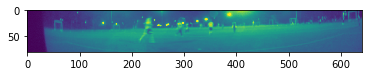

In [3]:
fetcher = Image_Fetcher('data/images/capture/', 'data/labels/rugby_image_labels_2.csv', [240,320])

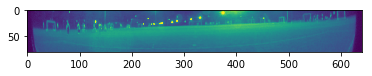

In [25]:
fetcher_2 = Image_Fetcher('data/images/capture clean/', 'data/labels/rugby_image_labels.csv', [240,320])

In [4]:
x, y = fetcher.get_all_images_with_labels(msg=False)

0
0
100
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [28]:
x_2, y_2 = fetcher_2.get_all_images_with_labels(msg=False)

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


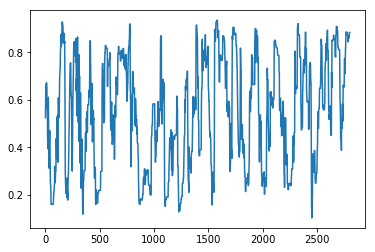

In [29]:
plt.plot(y)
plt.show()

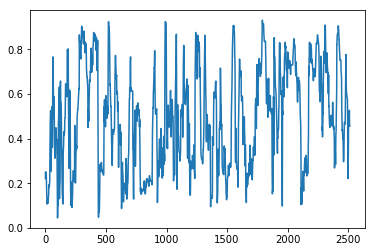

In [30]:
plt.plot(y_2)
plt.show()

## Stack images pair-wise

In [34]:
x_c_1, y_c_1 = Image_Fetcher.time_stack_data(x, y, time_frames=2)
x_c_2, y_c_2 = Image_Fetcher.time_stack_data(x_2, y_2, time_frames=2)

chron_X = np.concatenate([x_c_1,x_c_2])
chron_y = np.concatenate([y_c_1, y_c_2])
# chron_X, chron_y = Image_Fetcher.time_stack_data(x, y, time_frames=2)

chron_X.shape, chron_y.shape

(2804, 2, 16, 50) (2804,)
(2513, 2, 16, 50) (2513,)


((5317, 2, 16, 50), (5317,))

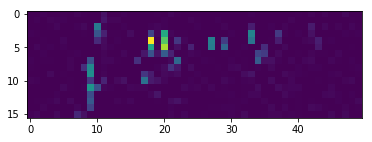

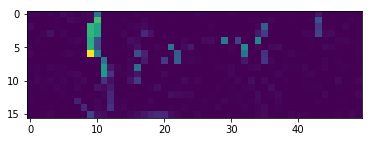

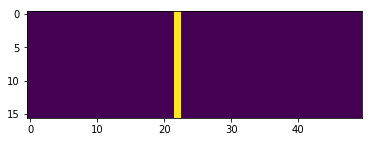

0.44375


In [38]:
Image_Fetcher.show_frame_sequence(chron_X, chron_y, 3000)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    chron_X, chron_y, test_size=0.33, random_state=42)

In [40]:
X_train.shape[-2:]

(16, 50)

# Define model

In [41]:
def add_1(arr, front=False):
    '''
    Becuase keras want a channel dimension
    '''
    if front:
        return arr.reshape([1,*arr.shape])
    return arr.reshape([*arr.shape,1])

In [42]:
chron_model = Sequential()

chron_model.add(ConvLSTM2D(3, kernel_size=(3, 3), 
                 input_shape=(None ,*X_train.shape[-2:], 1), name='input', return_sequences=True))
chron_model.add(Dropout(0.5))
# chron_model.add(BatchNormalization())
chron_model.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same', name='input2'))
chron_model.add(Flatten())
chron_model.add(Dense(128, activation='relu'))
chron_model.add(Dropout(0.5))
chron_model.add(Dense(64, activation='relu'))
chron_model.add(Dense(32, activation='relu'))
# chron_model.add(Dropout(0.1))
chron_model.add(Dense(1, name='output'))

In [43]:
chron_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (ConvLSTM2D)           (None, None, 14, 48, 3)   444       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 14, 48, 3)   0         
_________________________________________________________________
input2 (ConvLSTM2D)          (None, 14, 48, 3)         660       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2016)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               258176    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
__________

In [44]:
chron_model.compile(loss='mean_absolute_percentage_error', optimizer='rmsprop')

In [48]:
chron_model.fit(add_1(X_train), y_train,
          batch_size=30,
          epochs=20,
          verbose=1,
          validation_data=(add_1(X_test), add_1(y_test)))

Train on 3562 samples, validate on 1755 samples
Epoch 1/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.9559 - val_loss: 16.4719
Epoch 2/20
3562/3562 [==============================] - 19s 5ms/step - loss: 9.8415 - val_loss: 16.2047
Epoch 3/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.9252 - val_loss: 15.8975
Epoch 4/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.7918 - val_loss: 15.9126
Epoch 5/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.4372 - val_loss: 15.9278
Epoch 6/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.6738 - val_loss: 16.1450
Epoch 7/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.4555 - val_loss: 15.8830
Epoch 8/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.6580 - val_loss: 16.3628
Epoch 9/20
3562/3562 [==============================] - 18s 5ms/step - loss: 9.6229 - val_loss: 16.1688
Epoch 10/20
3562

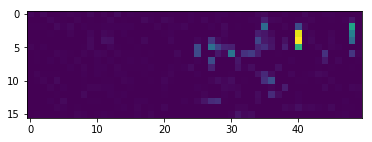

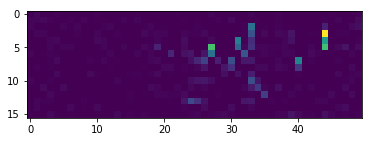

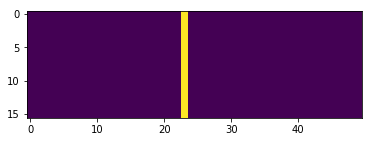

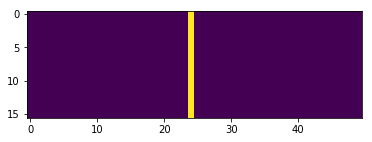

0.493727
0.4734375


In [49]:
#  test some frames
i = 600

plt.imshow(chron_X[i,0,:,:])
plt.show()

plt.imshow(chron_X[i,1,:,:])
plt.show()

correct_output = np.zeros(chron_X[i,0,:,:].shape)
correct_output[:,int(correct_output.shape[1]*chron_y[i])] = 1

plt.imshow(correct_output)
plt.show()


prediction = chron_model.predict(add_1( add_1( chron_X[i]), True) )[0][0]

predict_output = np.zeros(chron_X[i,0,:,:].shape)
predict_output[:,int(correct_output.shape[1]*prediction)] = 1

plt.imshow(predict_output)
plt.show()

print(prediction)
print(chron_y[i])

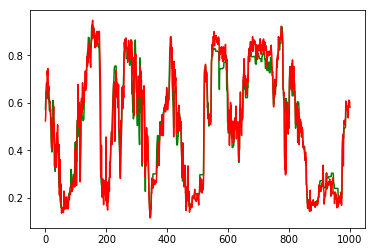

In [51]:
n = 1000
plt.plot(chron_y[:n], c='g')
plt.plot(chron_model.predict(add_1( chron_X[:n]) ), c='r')
plt.show()

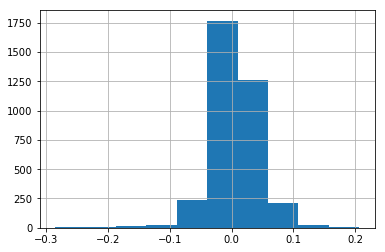

In [52]:
residals = (chron_model.predict(add_1(X_train)) - add_1(y_train))[:,0]

pd.Series(residals).hist()

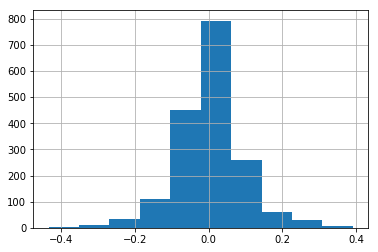

In [53]:
residals = (chron_model.predict(add_1(X_test)) - add_1(y_test))[:,0]

pd.Series(residals).hist()

In [54]:
chron_model.save('rcnn.h5')

In [55]:
chron_model.count_params()

269649